In [ ]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.2/691.2 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 60.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

Using TensorFlow backend
TensorFlow version: 2.18.0
KerasNLP version: 0.18.1


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahdibaharestani","key":"882146e513cffad7826a05deef554939"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 99.9MB/s]


In [ ]:
from zipfile import ZipFile

ZipFile('nlp-getting-started.zip').extractall()

In [ ]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/train.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (7613, 5)
Test Set Memory Usage = 0.29 MB


In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64


In [ ]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

In [ ]:
# Create datasets

preset = 'bert_tiny_en_uncased'

preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    preset,
    sequence_length=157
)


train_dataset = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .map(lambda x, y: (preprocessor(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .map(lambda x, y: (preprocessor(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

100%|██████████| 507/507 [00:00<00:00, 1.16MB/s]


100%|██████████| 547/547 [00:00<00:00, 699kB/s]


100%|██████████| 226k/226k [00:00<00:00, 1.24MB/s]


In [ ]:
classifier = keras_nlp.models.BertClassifier.from_preset(preset,
                                                          preprocessor=None,
                                                          num_classes=2)
classifier.fit(train_dataset,
               epochs=2,
               validation_data=test_dataset)

100%|██████████| 16.8M/16.8M [00:00<00:00, 25.8MB/s]


Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - loss: 0.6434 - sparse_categorical_accuracy: 0.6246 - val_loss: 0.4769 - val_sparse_categorical_accuracy: 0.7978
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.4721 - sparse_categorical_accuracy: 0.7916 - val_loss: 0.4183 - val_sparse_categorical_accuracy: 0.8234


In [ ]:
import keras_nlp
import tensorflow as tf
from tensorflow.keras import layers

# Load Small BERT preprocessor and encoder

bert_preprocessor = keras_nlp.models.BertPreprocessor.from_preset(preset,
                                                                  sequence_length=157)
bert_backbone = keras_nlp.models.BertBackbone.from_preset(preset)

# Create datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .map(bert_preprocessor, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .map(bert_preprocessor, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

bert_backbone.trainable = False

# Build a custom classification model
inputs = bert_backbone.input
sequence = bert_backbone(inputs)['sequence_output']

# Use the pooled output (e.g., from the [CLS] token) for classification
for _ in range(2):
  sequence = keras_nlp.layers.TransformerEncoder(
      num_heads=2,
      intermediate_dim=512,
      dropout=.1
  )(sequence)

outputs = layers.Dense(2)(sequence[:,bert_backbone.cls_token_index,:])

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)


# Compile the model
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics=["accuracy"],
)


model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer) │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ segment_ids (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_ids (InputLayer)    │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_backbone             │ [(None, 128), (None,   │      4,385,920 │ padding_mask[0][0],    │
│ (BertBackbone)            │ None, 128)]            │                │ segment_ids[0][0],     │
│                           │                        │                │ token_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder       │ (None, None, 128)      │        198,272 │ bert_backbone[0][1]    │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_1     │ (None, None, 128)      │        198,272 │ transformer_encoder[0… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 128)            │              0 │ transformer_encoder_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2)              │            258 │ get_item_2[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,782,722 (18.24 MB)

 Trainable params: 396,802 (1.51 MB)

 Non-trainable params: 4,385,920 (16.73 MB)

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset,
)

Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 38s 105ms/step - accuracy: 0.5608 - loss: 0.7628 - val_accuracy: 0.7150 - val_loss: 0.5636
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6841 - loss: 0.6022 - val_accuracy: 0.7584 - val_loss: 0.5156


## Evaluating simple classifier

In [ ]:
preprocessed_x_test = bert_preprocessor(df_test['text'])

preds = classifier.predict(preprocessed_x_test)
preds

238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


array([[-0.19530085, -0.03846467],
       [-1.0369914 ,  0.80927056],
       [-1.2898782 ,  0.93378836],
       ...,
       [-1.0035378 ,  0.96703   ],
       [-0.9683853 ,  0.72139   ],
       [-1.2983522 ,  1.097094  ]], dtype=float32)

In [ ]:
y_pred = tf.argmax(preds,axis=1)
y_pred

<tf.Tensor: shape=(7613,), dtype=int64, numpy=array([1, 1, 1, ..., 1, 1, 1])>

In [ ]:
from sklearn.metrics import confusion_matrix
y_true = df_test['target']

bert_classifier_CM = confusion_matrix(y_true=y_true,
                                      y_pred=y_pred)
bert_classifier_CM

array([[4000,  342],
       [ 886, 2385]])

In [ ]:
from sklearn.metrics import f1_score, ConfusionMatrixDisplay

f1_score(y_true,y_pred)

0.7952650883627876

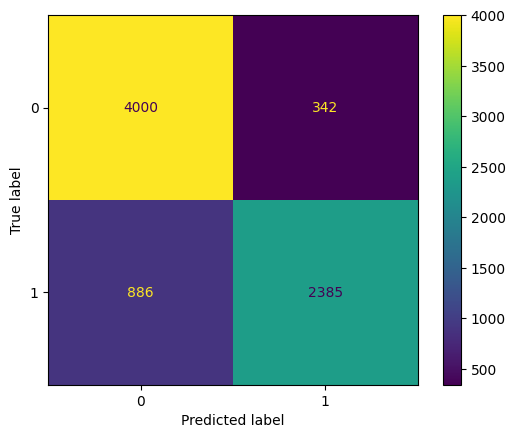

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_true,y_pred)

## Evaluating BERT Backbone (without fine tuning)

In [ ]:
bert_preds = model.predict(preprocessed_x_test)
bert_preds

238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


array([[ 1.047012  , -0.28912857],
       [-2.148568  , -0.28245786],
       [-0.30846944,  1.8284801 ],
       ...,
       [-1.2065538 , -0.25104463],
       [-0.51972294, -0.15266041],
       [-0.9818295 , -0.17176445]], dtype=float32)

In [ ]:
bert_y_pred = tf.argmax(bert_preds,axis=1)
bert_y_pred

<tf.Tensor: shape=(7613,), dtype=int64, numpy=array([0, 1, 1, ..., 1, 1, 1])>

In [ ]:
f1_score(y_true,bert_y_pred)

0.7107013301088271

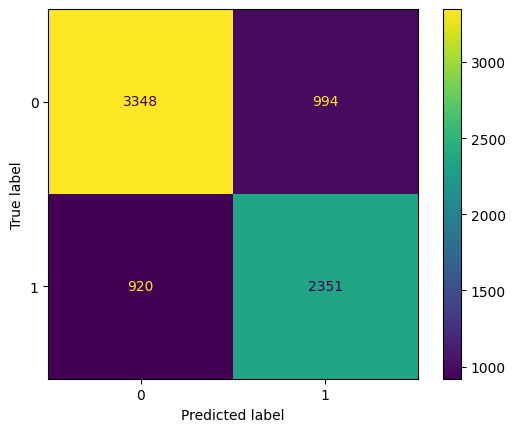

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_true,bert_y_pred);

# Fine-Tuning BERT

In [ ]:
# Lets fine tune the model in hope of better results

bert_backbone.trainable = True
for layer in bert_backbone.layers[:-3]:
    layer.trainable=False

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(monitor='val_loss',
                             patience=3,
                             restore_best_weights=True)


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer) │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ segment_ids (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_ids (InputLayer)    │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_backbone             │ [(None, 128), (None,   │      4,385,920 │ padding_mask[0][0],    │
│ (BertBackbone)            │ None, 128)]            │                │ segment_ids[0][0],     │
│                           │                        │                │ token_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder       │ (None, None, 128)      │        198,272 │ bert_backbone[0][1]    │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_1     │ (None, None, 128)      │        198,272 │ transformer_encoder[0… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 128)            │              0 │ transformer_encoder_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2)              │            258 │ get_item_2[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,782,722 (18.24 MB)

 Trainable params: 809,858 (3.09 MB)

 Non-trainable params: 3,972,864 (15.16 MB)

In [ ]:
history_1 = model.fit(train_dataset,
                      epochs=10,
                      validation_data=test_dataset,
                      callbacks=[earlystopping])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


191/191 ━━━━━━━━━━━━━━━━━━━━ 44s 100ms/step - accuracy: 0.6972 - loss: 0.6786 - val_accuracy: 0.7800 - val_loss: 0.4849
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7822 - loss: 0.4929 - val_accuracy: 0.7781 - val_loss: 0.4869
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.7843 - loss: 0.4742 - val_accuracy: 0.7991 - val_loss: 0.4403
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8088 - loss: 0.4438 - val_accuracy: 0.8194 - val_loss: 0.4369
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8033 - loss: 0.4393 - val_accuracy: 0.8017 - val_loss: 0.4436
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8123 - loss: 0.4337 - val_accuracy: 0.8063 - val_loss: 0.4528
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7946 - loss: 0.4614 - val_accuracy: 0.7833 - val_loss: 0.4806


## Evaluating fine-tuned model

In [ ]:
fine_tune_preds = model.predict(preprocessed_x_test)
fine_tune_preds = tf.argmax(fine_tune_preds,axis=1)
fine_tune_preds

238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


<tf.Tensor: shape=(7613,), dtype=int64, numpy=array([0, 1, 1, ..., 1, 1, 1])>

In [ ]:
f1_score(y_true,fine_tune_preds)

0.7951331798750411

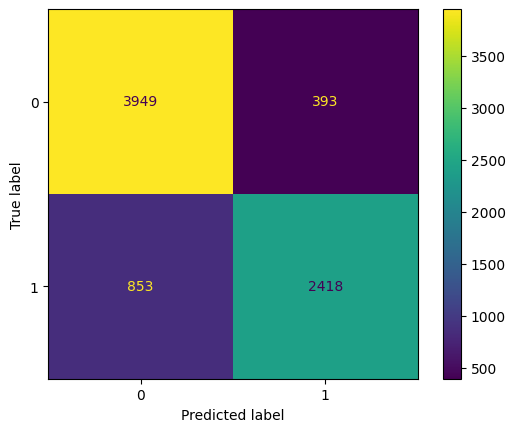

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_true,fine_tune_preds)

# Trying more complicated model

In [ ]:
# Let's unfreeze more layers and add dropout and dense layer to the model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam


# Unfreeze the last few layers of the BERT encoder
for layer in bert_backbone.layers[:-5]:
    layer.trainable = True


def lr_schedule(epoch, lr):
    initial_lr = 1e-5
    warmup_epochs = 3
    decay_epochs = 7
    total_epochs = 10
    end_lr = 0.0

    # Gradually increase the learning rate during the warm-up period
    if epoch < warmup_epochs:
        return initial_lr * (epoch / warmup_epochs)

    # Then decay the learning rate after the warm-up phase
    else:
        decay_rate = (end_lr - initial_lr) / decay_epochs
        return initial_lr + decay_rate * (epoch - warmup_epochs)

# Define the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers


# Build a more sophisticated classification model
inputs = bert_backbone.input
sequence = bert_backbone(inputs)['sequence_output']


for _ in range(2):
  sequence = keras_nlp.layers.TransformerEncoder(
      num_heads=2,
      intermediate_dim=512,
      dropout=.1
  )(sequence)

outputs = layers.Dense(120,activation='relu')(sequence[:,bert_backbone.cls_token_index,:])
outputs = layers.Dropout(0.2)(outputs)
outputs = layers.Dense(2,activation='softmax')(outputs)

bert_classifier_fine_tune = tf.keras.Model(inputs,outputs)

bert_classifier_fine_tune.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                                 optimizer=Adam(learning_rate=1e-5),
                                 metrics=['accuracy'])

bert_classifier_fine_tune.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer) │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ segment_ids (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_ids (InputLayer)    │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_backbone             │ [(None, 128), (None,   │      4,385,920 │ padding_mask[0][0],    │
│ (BertBackbone)            │ None, 128)]            │                │ segment_ids[0][0],     │
│                           │                        │                │ token_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_2     │ (None, None, 128)      │        198,272 │ bert_backbone[1][1]    │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_3     │ (None, None, 128)      │        198,272 │ transformer_encoder_2… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 128)            │              0 │ transformer_encoder_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 120)            │         15,480 │ get_item_3[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 120)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │            242 │ dropout_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,798,186 (18.30 MB)

 Trainable params: 4,798,186 (18.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_2 = bert_classifier_fine_tune.fit(train_dataset,
                                         epochs=10,
                                         initial_epoch=len(history_1.epoch),
                                         validation_data=test_dataset,
                                         callbacks=[earlystopping,lr_scheduler])

Epoch 8/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


191/191 ━━━━━━━━━━━━━━━━━━━━ 58s 172ms/step - accuracy: 0.6781 - loss: 0.6184 - val_accuracy: 0.8017 - val_loss: 0.4721 - learning_rate: 4.2857e-06
Epoch 9/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.7916 - loss: 0.4910 - val_accuracy: 0.8063 - val_loss: 0.4683 - learning_rate: 2.8571e-06
Epoch 10/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7964 - loss: 0.4937 - val_accuracy: 0.8050 - val_loss: 0.4646 - learning_rate: 1.4286e-06


#### It seems like we are not making that much of a progress...!!!🧐🧐

In [ ]:
# Let's make some predictions with this new model

new_preds = bert_classifier_fine_tune.predict(preprocessed_x_test)
new_preds = tf.argmax(new_preds,axis=1)
new_preds

238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


<tf.Tensor: shape=(7613,), dtype=int64, numpy=array([0, 1, 1, ..., 1, 1, 1])>

In [ ]:
f1_score(y_true,new_preds)

0.772689700776988

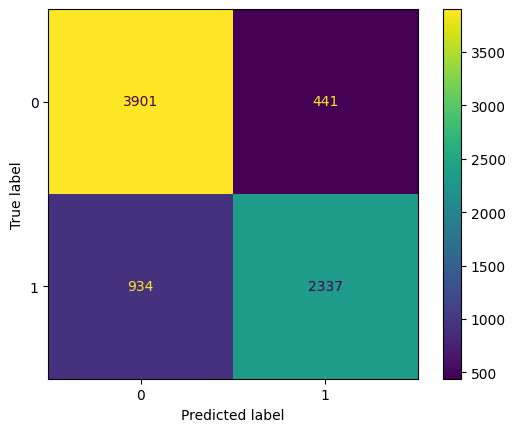

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_true,new_preds)

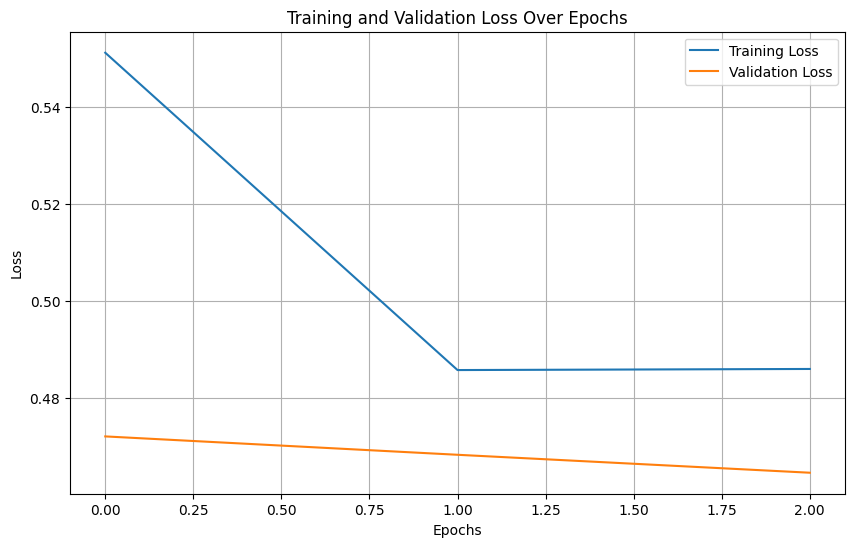

In [ ]:
# Plottting loss curve
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

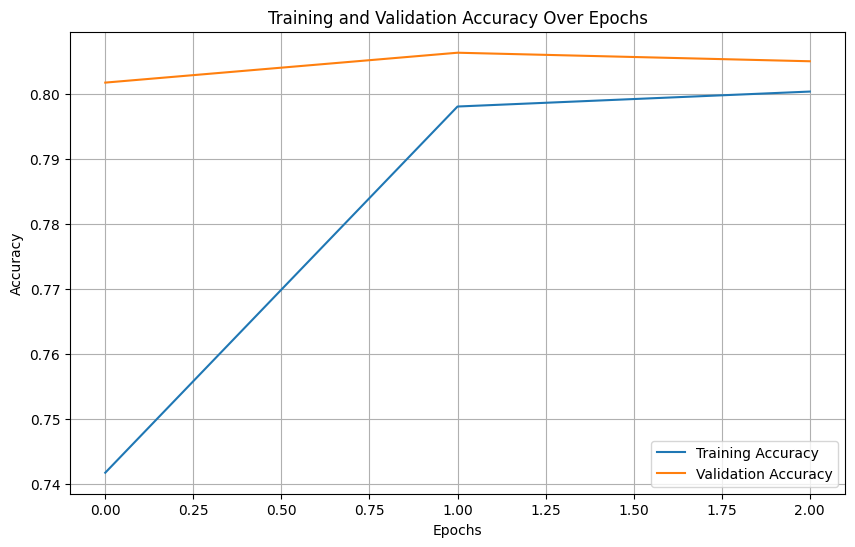

In [ ]:
# Plotting accuracy

plt.figure(figsize=(10, 6))
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


# Our strategies for imporving model perfomance from now on:
### * Preprocessing data
### * Using data augmentation
### * Exploring different loss functions

## Preprocessing the data

In [ ]:
import re

# New preprocessing function
def custome_preprocessor(text):
    """
    Preprocess disaster tweets by handling mentions, hashtags, and links.

    Args:
        text (str): The input tweet.

    Returns:
        str: The preprocessed tweet.
    """
    # Replace mentions with a placeholder
    text = re.sub(r'@\w+', '[USER]', text)

    # Replace URLs with a placeholder
    text = re.sub(r'http\S+|www\.\S+', '[LINK]', text)

    # Remove hashtags but retain their content
    text = re.sub(r'#(\w+)', r'\1', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Preprocessing the data
X_train_preprocessed = X_train.apply(custome_preprocessor)
X_val_preprocessed = X_val.apply(custome_preprocessor)



# Creating new datasets

train_dataset = (
    tf.data.Dataset.from_tensor_slices((X_train_preprocessed, y_train))
    .map(bert_preprocessor, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((X_val_preprocessed, y_val))
    .map(bert_preprocessor, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
history_3 = bert_classifier_fine_tune.fit(train_dataset,
                                         epochs=10,
                                         initial_epoch=len(history_2.epoch),
                                         validation_data=test_dataset,
                                         callbacks=[earlystopping,lr_scheduler])

Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7862 - loss: 0.4990 - val_accuracy: 0.8024 - val_loss: 0.4538 - learning_rate: 1.0000e-05
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.7970 - loss: 0.4645 - val_accuracy: 0.8116 - val_loss: 0.4426 - learning_rate: 8.5714e-06
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8128 - loss: 0.4461 - val_accuracy: 0.8109 - val_loss: 0.4408 - learning_rate: 7.1429e-06


### Unfreezing more layers

In [ ]:
# Unfreeze the last 7 layers of the BERT encoder
for layer in bert_backbone.layers[-7:]:
    layer.trainable = True

In [ ]:
# Recompiling the model

bert_classifier_fine_tune.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                                 optimizer=Adam(learning_rate=1e-5),
                                 metrics=['accuracy'])

bert_classifier_fine_tune.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer) │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ segment_ids (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_ids (InputLayer)    │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_backbone             │ [(None, 128), (None,   │      4,385,920 │ padding_mask[0][0],    │
│ (BertBackbone)            │ None, 128)]            │                │ segment_ids[0][0],     │
│                           │                        │                │ token_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_2     │ (None, None, 128)      │        198,272 │ bert_backbone[1][1]    │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_3     │ (None, None, 128)      │        198,272 │ transformer_encoder_2… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 128)            │              0 │ transformer_encoder_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 120)            │         15,480 │ get_item_3[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 120)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │            242 │ dropout_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,798,186 (18.30 MB)

 Trainable params: 4,798,186 (18.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Evaluating the performance

history_4 = bert_classifier_fine_tune.fit(train_dataset,
                                         epochs=10,
                                         initial_epoch=len(history_3.epoch),
                                         validation_data=test_dataset,
                                         callbacks=[earlystopping,lr_scheduler])

Epoch 4/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


191/191 ━━━━━━━━━━━━━━━━━━━━ 48s 123ms/step - accuracy: 0.7938 - loss: 0.4619 - val_accuracy: 0.8089 - val_loss: 0.4410 - learning_rate: 1.0000e-05
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8083 - loss: 0.4457 - val_accuracy: 0.8109 - val_loss: 0.4359 - learning_rate: 8.5714e-06
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8133 - loss: 0.4414 - val_accuracy: 0.8148 - val_loss: 0.4304 - learning_rate: 7.1429e-06
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8112 - loss: 0.4263 - val_accuracy: 0.8142 - val_loss: 0.4311 - learning_rate: 5.7143e-06
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8245 - loss: 0.4183 - val_accuracy: 0.8162 - val_loss: 0.4303 - learning_rate: 4.2857e-06
Epoch 9/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8225 - loss: 0.4115 - val_accuracy: 0.8168 - val_loss: 0.4313 - learning_rate: 2.8571e-06
Epoch 10/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 

Ooopss...!

## Data Augmentation

In [ ]:
import nltk
from nltk.corpus import wordnet
from nltk import pos_tag

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')  # Download the Open Multilingual WordNet if it's needed

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


### Synonym Replacement Function

### Coding my costume pipeline

In [ ]:
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
import string
import spacy
import tensorflow_hub as hub
import tensorflow as tf
import random
import numpy as np
from transformers import pipeline
from scipy.special import softmax

# Initialize the BERT fill-mask pipeline
bert_mask_filler = pipeline("fill-mask", model="bert-base-uncased",device=0)
stopwords_set = set(stopwords.words('english') + list(string.punctuation) + ["''", "``"])

def filter_synonyms_with_bert(sentence, masked_word, synonyms):
    """
    Use BERT to filter synonyms based on their contextual relevance to the sentence.
    """
    # Mask the original word in the sentence
    masked_sentence = sentence.replace(masked_word, "[MASK]", 1)
    # print(f'masked sentence:{masked_sentence}\n')

    # Get BERT predictions for the [MASK] token
    predictions = bert_mask_filler(masked_sentence)
    # print(f'bert predictions:{predictions}\n')

    scored_synonyms = []

    for pred in predictions:
        if pred != masked_word and not pred['token_str'].startswith('#'):
            scored_synonyms.append((pred['token_str'],pred['score']))

    # If no synonyms scored by BERT, return an empty list
    if not scored_synonyms:
        return []

    # print(f'scored synonyms by bert un-normalized:{scored_synonyms}\n')
    # Sort synonyms by score in descending order
    scored_synonyms.sort(key=lambda x: x[1], reverse=True)
    values = [x[1] for x in scored_synonyms]
    normalized_values = softmax(values)

    return [(x[0],sm) for x, sm in zip(scored_synonyms,normalized_values)]


def masking_word(sentence):
    words = sentence.split()
    non_stopwords = [word for word in words if word.lower() not in stopwords_set and word.isalpha()]
    if not non_stopwords:
        return None, None, None

    random_word = random.choice(non_stopwords)
    rw_idx = words.index(random_word)
    masked_sentence = sentence.replace(random_word,'[MASK]',1)

    return ''.join(masked_sentence), random_word, rw_idx


def replace_with_synonym(sentence, top_k=5,threshold=0.9):

    msk_sen, random_word, rw_idx = masking_word(sentence)

    # Handle cases where no valid word is found
    if random_word is None:
        return []
    # print(f'masked word:{random_word}\n')

    synonyms = set()
    # Get synsets and filter synonyms based on POS
    masked_word_synsets = wordnet.synsets(random_word)
    tagged = pos_tag([random_word])[0]  # POS tag for masked word
    masked_word_pos = tagged[1][0].lower()

    for syn in masked_word_synsets:
        if syn.pos() == masked_word_pos:  # Only match same POS
            for lemma in syn.lemmas():
                synonym = lemma.name().replace('_', ' ')
                if synonym.lower() != random_word.lower():  # Avoid adding the original word
                    synonyms.add(synonym)

    # print(f'synonyms:{synonyms}\n')
    if not synonyms:
        return []

    # Filter synonyms with BERT
    scored_synonyms = filter_synonyms_with_bert(sentence, random_word, synonyms)

    # print(f'scored synonyms by bert:{scored_synonyms}')
    final_synonyms = [syn for syn, score in scored_synonyms if score >= threshold]

    # print(f'final synonyms:{final_synonyms}')
    return [msk_sen.replace('[MASK]',syn,1) for syn in final_synonyms[:top_k]]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
sample = random.choice(X_train.values.tolist())
print(sample,'\n')
preprocessed_sample = custome_preprocessor(sample)
print(f'preprocessed sentence:\n{preprocessed_sample}\n')
replace_with_synonym(preprocessed_sample,threshold=0.2)

@alanhahn @HDumpty39 Daughtery would get destroyed on twitter. His comments are emotionally driven rants with little factual basis 

preprocessed sentence:
[USER] [USER] Daughtery would get destroyed on twitter. His comments are emotionally driven rants with little factual basis



[]

In [ ]:
# Lets define a funtion that applies the preprocessing and augments dataset

from tqdm import tqdm  # Progress bar for better tracking

def data_augmenter(data,threshold: float,top_k: int, column: str = None):
  tqdm.pandas()
  new_data = data.copy()
  if isinstance(data, pd.Series):
    new_data = new_data.to_frame()

  elif column not in new_data.columns:
    raise ValueError(f"The specified column '{column}' does not exist in the DataFrame.")


  new_data['preprocessed_tweet'] = new_data[column].progress_apply(custome_preprocessor)

  # Apply synonym replacement
  new_data['tweet_augmented'] = new_data['preprocessed_tweet'].progress_apply(
      lambda x: replace_with_synonym(x, top_k=top_k, threshold=threshold)
  )

  return new_data

In [ ]:
augmented_df = data_augmenter(df_train,threshold=0.2,top_k=5,column='text')
augmented_df

100%|██████████| 7613/7613 [01:05<00:00, 115.39it/s]


,id,keyword,location,text,target,length,preprocessed_tweet,tweet_augmented
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,Our Deeds are the Reason of this earthquake Ma...,[]
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,Forest fire near La Ronge Sask. Canada,[]
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,All residents asked to 'shelter in place' are ...,[All residents asked to 'shelter in place' are...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,"13,000 people receive wildfires evacuation ord...","[13,000 people receive emergency evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,Just got sent this photo from Ruby Alaska as s...,[Just got sent this morning from Ruby Alaska a...
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83,Two giant cranes holding a bridge collapse int...,[Two giant figures holding a bridge collapse i...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125,[USER] [USER] The out of control wild fires in...,[]
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. [LINK],[M1.94 [01:04 UTC]?5km S of the Hawaii. [LINK]...
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,137,Police investigating after an e-bike collided ...,[]


In [ ]:
augmented_df = augmented_df.drop(['id','keyword','location','text'],axis=1)
augmented_df

,target,length,preprocessed_tweet,tweet_augmented
0,1,69,Our Deeds are the Reason of this earthquake Ma...,[]
1,1,38,Forest fire near La Ronge Sask. Canada,[Forest reserve near La Ronge Sask. Canada]
2,1,133,All residents asked to 'shelter in place' are ...,[All residents asked to 'shelter in place' are...
3,1,65,"13,000 people receive wildfires evacuation ord...","[13,000 people receive wildfires evacuation or..."
4,1,88,Just got sent this photo from Ruby Alaska as s...,[Just got sent this photo from Ruby Alaska as ...
...,...,...,...,...
7608,1,83,Two giant cranes holding a bridge collapse int...,[]
7609,1,125,[USER] [USER] The out of control wild fires in...,[[USER] [USER] The out of date wild fires in C...
7610,1,65,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. [LINK],[M1.94 [01:04 UTC]?5km S of the Hawaii. [LINK]...
7611,1,137,Police investigating after an e-bike collided ...,[Police investigating after an e-bike collided...


In [ ]:
expanded_rows = []

for _, row in augmented_df.iterrows():
    target = row['target']
    preprocessed_tweet = row['preprocessed_tweet']
    augmented_sentences = row['tweet_augmented']

    if augmented_sentences:  # Avoid empty lists
        for sentence in augmented_sentences:
            expanded_rows.append({
                'target': target,
                'preprocessed_tweet': preprocessed_tweet,
                'augmented_sentence': sentence
            })
# expanded_rows
# # Create a new dataframe from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

# expanded_df = expanded_df.drop('preprocessed_tweet',axis=1)
expanded_df

,target,preprocessed_tweet,augmented_sentence
0,1,Our Deeds are the Reason of this earthquake Ma...,Our Deeds are the Reason of this earthquake . ...
1,1,All residents asked to 'shelter in place' are ...,All residents asked to 'shelter in place' are ...
2,1,"13,000 people receive wildfires evacuation ord...","13,000 people receive wildfires evacuation ord..."
3,1,"13,000 people receive wildfires evacuation ord...","13,000 people receive wildfires evacuation ord..."
4,1,Just got sent this photo from Ruby Alaska as s...,Just got sent this photo from Ruby Alaska as s...
...,...,...,...
8455,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. [LINK],M1.94 [01:04 UTC]?5km S of central Hawaii. [LINK]
8456,1,Police investigating after an e-bike collided ...,Police investigating after an e-bike collided ...
8457,1,Police investigating after an e-bike collided ...,Police investigating after an e-bike collided ...
8458,1,The Latest: More Homes Razed by Northern Calif...,The Latest: More Homes Razed by Northern Calif...


In [ ]:
expanded_df["target"].value_counts()

,count
target,
0,4707
1,3753


In [ ]:
X_a = expanded_df["augmented_sentence"]
y_a = expanded_df["target"]

X_train_a, X_val_a, y_train_a, y_val_a = train_test_split(X_a, y_a,
                                                          test_size=.1,
                                                          random_state=42)

In [ ]:
X_train_a

,augmented_sentence
7085,Suicide Bomber june 13 At Saudi Mosque [LINK] ...
7428,Heavy rain frequent thunder and gusty winds mo...
7490,[USER] worse than tornado!
6999,[USER] [USER] [USER] [USER] send me a picture ...
50,[USER] huge fire at Wholesale stands ablaze [L...
...,...
5734,Drunk Meals 101: What To Cook When You're Tota...
5191,Listening to my grandad talk about his life is...
5390,[USER] the mass murder got her hot and bothere...
860,black Blight Thank you for following me!!


In [ ]:
# Convert to tf.data.Dataset using preprocessed inputs
train_dataset_a = (
  tf.data.Dataset.from_tensor_slices((X_train_a, y_train_a))
  .map(lambda x,y: (bert_preprocessor(x),y), num_parallel_calls=tf.data.AUTOTUNE)
  .batch(BATCH_SIZE)
  .prefetch(tf.data.AUTOTUNE)
)

test_dataset_a = (
    tf.data.Dataset.from_tensor_slices((X_val_a, y_val_a))
    .map(lambda x,y: (bert_preprocessor(x),y), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
history_5 = bert_classifier_fine_tune.fit(train_dataset_a,
                             epochs=10,
                             validation_data=test_dataset_a,
                             callbacks=[earlystopping,lr_scheduler])

Epoch 1/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 24s 99ms/step - accuracy: 0.8016 - loss: 0.4577 - val_accuracy: 0.8193 - val_loss: 0.4055 - learning_rate: 0.0000e+00
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8079 - loss: 0.4497 - val_accuracy: 0.8252 - val_loss: 0.3974 - learning_rate: 3.3333e-06
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.8023 - loss: 0.4482 - val_accuracy: 0.8240 - val_loss: 0.3910 - learning_rate: 6.6667e-06
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8089 - loss: 0.4369 - val_accuracy: 0.8300 - val_loss: 0.3829 - learning_rate: 1.0000e-05
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8218 - loss: 0.4236 - val_accuracy: 0.8347 - val_loss: 0.3781 - learning_rate: 8.5714e-06
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.8164 - loss: 0.4237 - val_accuracy: 0.8371 - val_loss: 0.3754 - learning_rate: 7.1429e-06
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - 

Now we're talking...!!!

In [ ]:
# Let's make some predictions with this new model

new_preds = bert_classifier_fine_tune.predict(bert_preprocessor(X_val_a))
new_preds = tf.argmax(new_preds,axis=1)
new_preds

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step


<tf.Tensor: shape=(841,), dtype=int64, numpy=
array([1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
     

In [ ]:
f1_score(y_val_a,new_preds)

0.8051575931232091

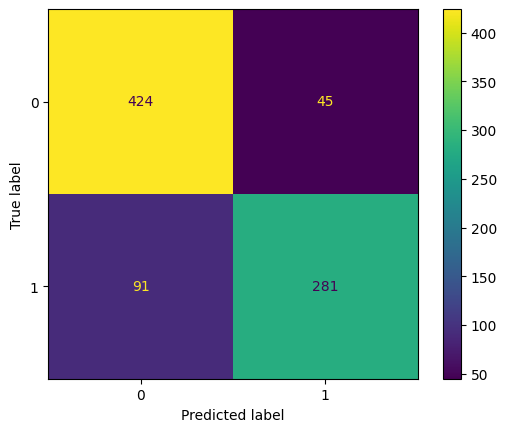

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_val_a,new_preds);

Way better....!!!

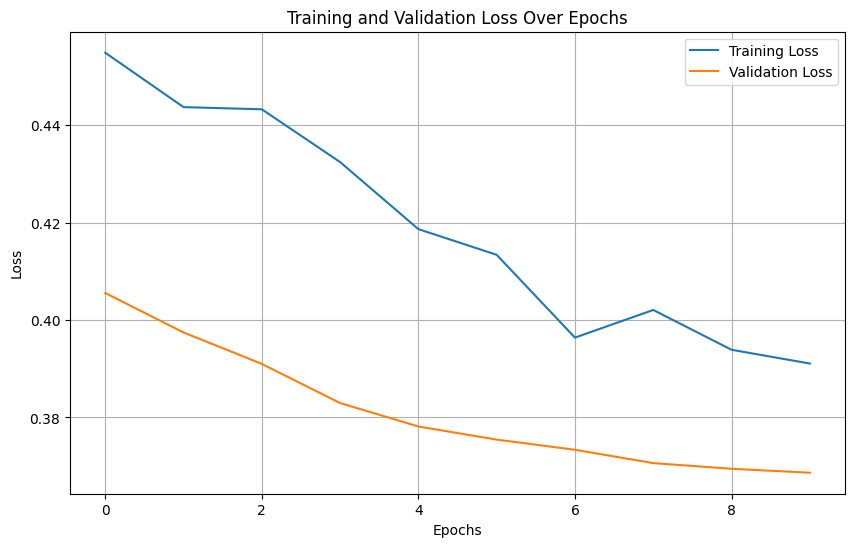

In [ ]:
# Checking loss and accuracy curve

# Plottting loss curve
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(history_5.history['loss'], label='Training Loss')
plt.plot(history_5.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

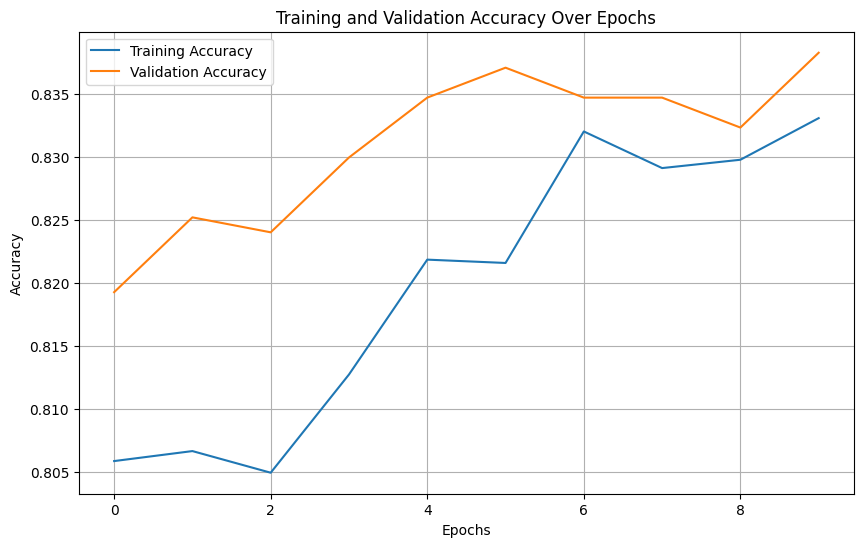

In [ ]:
# Plotting accuracy

plt.figure(figsize=(10, 6))
plt.plot(history_5.history['accuracy'], label='Training Accuracy')
plt.plot(history_5.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Testing the model on non-augmented data

non_aug_preds = bert_classifier_fine_tune.predict(bert_preprocessor(X_val))
non_aug_preds = tf.argmax(non_aug_preds,axis=1)
non_aug_preds

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


<tf.Tensor: shape=(1523,), dtype=int64, numpy=array([0, 0, 1, ..., 1, 1, 0])>

In [ ]:
f1_score(y_val,non_aug_preds)

0.7850911974623315

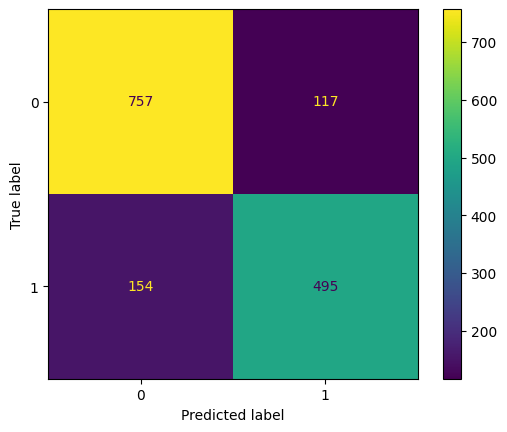

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_val,non_aug_preds);

*Looks like there is something wrong with our models since validation accuracy is higher than training and the validation loss is also lower.*

The first thing that comes to mind, is that it may be related to our dropout layers. So, lets try reducing the dropout percantage and re-evaluate our process.

### Reducing the dropout rate

In [ ]:
inputs = bert_backbone.input
sequence = bert_backbone(inputs)['sequence_output']


for _ in range(2):
  sequence = keras_nlp.layers.TransformerEncoder(
      num_heads=2,
      intermediate_dim=512,
      # dropout=.1   # Removing dropout from here.
  )(sequence)

outputs = layers.Dense(120,activation='relu')(sequence[:,bert_backbone.cls_token_index,:])
outputs = layers.Dropout(0.1)(outputs) # Reducing the dropout rate
outputs = layers.Dense(1,activation='sigmoid')(outputs) # Changing the activation function

bert_classifier_fine_tune_modified = tf.keras.Model(inputs,outputs)

bert_classifier_fine_tune_modified.compile(loss=tf.keras.losses.BinaryCrossentropy(), # changing the loss accoding to activation function.
                                 optimizer=Adam(learning_rate=1e-5),
                                 metrics=['accuracy'])

bert_classifier_fine_tune_modified.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer) │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ segment_ids (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_ids (InputLayer)    │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_backbone             │ [(None, 128), (None,   │      4,385,920 │ padding_mask[0][0],    │
│ (BertBackbone)            │ None, 128)]            │                │ segment_ids[0][0],     │
│                           │                        │                │ token_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_4     │ (None, None, 128)      │        198,272 │ bert_backbone[2][1]    │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_5     │ (None, None, 128)      │        198,272 │ transformer_encoder_4… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 128)            │              0 │ transformer_encoder_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 120)            │         15,480 │ get_item_4[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 120)            │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │            121 │ dropout_11[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,798,065 (18.30 MB)

 Trainable params: 4,798,065 (18.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_6 = bert_classifier_fine_tune_modified.fit(train_dataset_a,
                                                   epochs=10,
                                                   validation_data=test_dataset_a,
                                                   callbacks=[earlystopping,lr_scheduler])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 81ms/step - accuracy: 0.5514 - loss: 0.8437 - val_accuracy: 0.5589 - val_loss: 0.8497 - learning_rate: 0.0000e+00
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.6033 - loss: 0.7032 - val_accuracy: 0.8121 - val_loss: 0.4522 - learning_rate: 3.3333e-06
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.8098 - loss: 0.4504 - val_accuracy: 0.8276 - val_loss: 0.3971 - learning_rate: 6.6667e-06


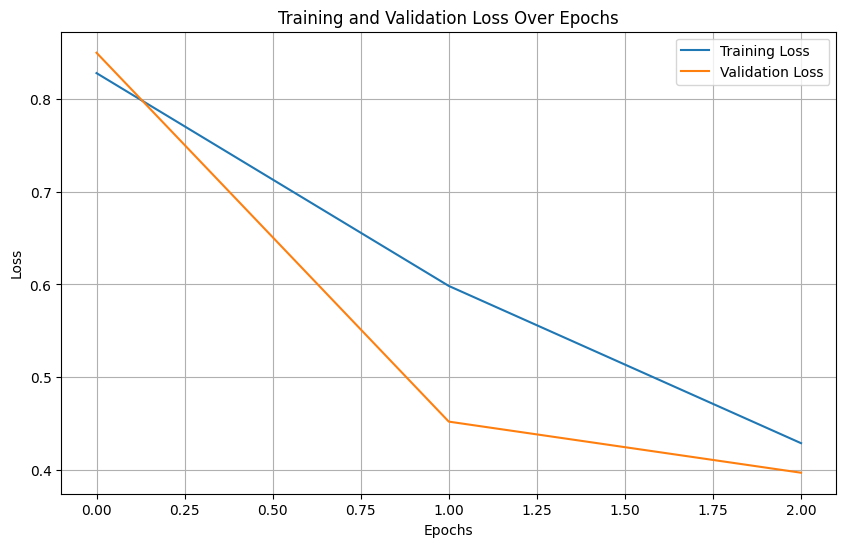

In [ ]:
import matplotlib.pyplot as plt

def plot_metric(history, metric):
    """
    Plots the training and validation curves for a given metric over epochs.

    Parameters:
    - history: History object from model training (history.history).
    - metric: The metric to plot ('loss' or 'accuracy').

    Returns:
    - None: Displays the plot.
    """
    if metric not in history.history:
        raise ValueError(f"Metric '{metric}' is not available in the model history.")
    if f'val_{metric}' not in history.history:
        raise ValueError(f"Validation metric 'val_{metric}' is not available in the model history.")

    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label=f'Training {metric.capitalize()}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.title(f'Training and Validation {metric.capitalize()} Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric(history_6, 'loss')

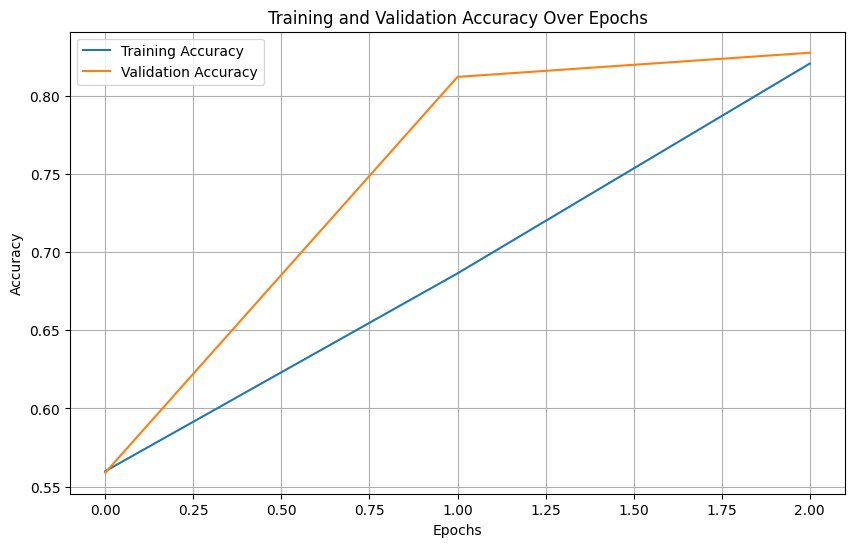

In [ ]:
plot_metric(history_6, 'accuracy')

In [ ]:
# Lets make some predictions with this new model

new_preds = bert_classifier_fine_tune_modified.predict(bert_preprocessor(X_val))
new_preds = tf.argmax(new_preds,axis=1)
new_preds

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step


<tf.Tensor: shape=(1523,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0])>

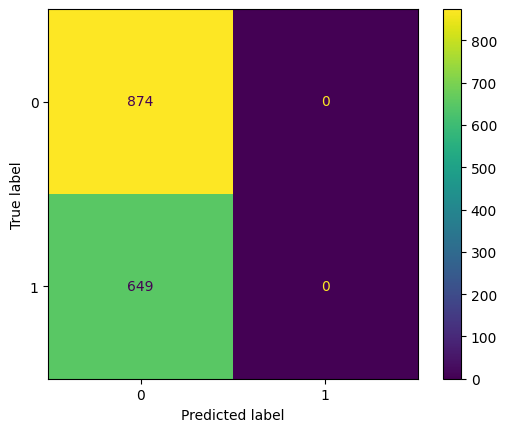

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_val,new_preds);

Looks like this approach did not do so well...!